In [1]:
!pip install umap
!pip install kneed

In [1]:
import doctest
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from sklearn.neighbors import NearestNeighbors
# from geopy.distance import geodesic
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
import umap.umap_ as umap
#from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cluster as cluster
from kneed import KneeLocator
from sklearn.model_selection import ParameterGrid
from sklearn.mixture import GaussianMixture
from sklearn.cluster import HDBSCAN
# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
sns.set_style("white")
sns.set_context("notebook")

In [2]:
plt.style.use('dark_background')

### Read in the data

In [3]:
housing_data_df = pd.read_csv(r'clean_housing_data_with_crime_rates.csv')
housing_data_df

,State,City,Street,Zipcode,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,...,house_coordinates,closest_city,city_coordinates,distance_to_maj_city_miles,population_y,violent_crime,prop_crime,larceny,vehicle_theft,difference_listed_vs_estimate
0,AL,Montgomery,Brampton Ln,36117.0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,...,"(32.372746, -86.165115)",Birmingham,"(33.5279, -86.7971)",87.664428,209018.0,0.001893,0.027600,0.017277,0.002520,500.0
1,AL,Montgomery,Crestview Ave,36109.0,3.0,2.0,2196.0,76.958106,0.6100,124700.0,...,"(32.39595, -86.269714)",Birmingham,"(33.5279, -86.7971)",83.806091,209018.0,0.001893,0.027600,0.017277,0.002520,44300.0
2,AL,Montgomery,Narrow Lane Rd,36116.0,3.0,3.0,3693.0,54.156512,6.9000,188300.0,...,"(32.273514, -86.25934)",Birmingham,"(33.5279, -86.7971)",91.920847,209018.0,0.001893,0.027600,0.017277,0.002520,11700.0
3,AL,Montgomery,E Delano Ave,36105.0,3.0,2.0,1428.0,90.966387,0.2600,127500.0,...,"(32.337, -86.29974)",Birmingham,"(33.5279, -86.7971)",87.007986,209018.0,0.001893,0.027600,0.017277,0.002520,2400.0
4,AL,Montgomery,George B Edmondson Dr,36110.0,3.0,1.0,1050.0,65.714286,0.1600,66500.0,...,"(32.40325, -86.28537)",Birmingham,"(33.5279, -86.7971)",83.007626,209018.0,0.001893,0.027600,0.017277,0.002520,2500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,WY,Green River,Colorado Dr,82935.0,5.0,3.0,3068.0,128.748370,0.2200,381000.0,...,"(41.494328, -109.45258)",Provo,"(40.2457, -111.6457)",143.591563,11927.0,0.001845,0.008133,0.007043,0.000168,14000.0
9632,WY,Evansville,Henrie Roadway,82636.0,2.0,2.0,2008.0,343.625498,4.6000,689900.0,...,"(42.86057, -106.10931)",Denver,"(39.762, -104.8758)",223.247715,2977.0,0.002351,0.024521,0.017467,0.002687,100.0
9633,WY,Evansville,6th St,82636.0,4.0,2.0,2022.0,157.270030,0.1828,311100.0,...,"(42.86506, -106.27643)",Denver,"(39.762, -104.8758)",226.191583,2977.0,0.002351,0.024521,0.017467,0.002687,6900.0
9634,WY,Evansville,6th St,82636.0,3.0,3.0,2300.0,143.434783,0.1739,329500.0,...,"(42.86544, -106.27745)",Denver,"(39.762, -104.8758)",226.233434,2977.0,0.002351,0.024521,0.017467,0.002687,400.0


In [4]:
housing_data_df.columns

Index(['State', 'City', 'Street', 'Zipcode', 'Bedroom', 'Bathroom', 'Area',
       'PPSq', 'LotArea', 'MarketEstimate', 'RentEstimate', 'Latitude',
       'Longitude', 'ListedPrice', 'density', 'source', 'military',
       'incorporated', 'timezone', 'ranking', 'zips', 'id',
       'house_coordinates', 'closest_city', 'city_coordinates',
       'distance_to_maj_city_miles', 'population_y', 'violent_crime',
       'prop_crime', 'larceny', 'vehicle_theft',
       'difference_listed_vs_estimate'],
      dtype='object')

In [5]:
# manipulating coordinates to be two separate variables + in separate columns for location purposes
housing_df_revised = housing_data_df[['Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate', 'RentEstimate', 'ListedPrice', 'difference_listed_vs_estimate', 'house_coordinates', 'distance_to_maj_city_miles', 'violent_crime', 'prop_crime', 'larceny', 'vehicle_theft']]
housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['house_coordinates'].str.strip('()').str.split(', ')))
housing_df_revised['x_house_coord'] = housing_df_revised['x_house_coord'].astype(float)
housing_df_revised['y_house_coord'] = housing_df_revised['y_house_coord'].astype(float)
housing_df_revised.drop(columns=['house_coordinates'], inplace=True)

/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_39697/1025807139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['house_coordinates'].str.strip('()').str.split(', ')))
/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_39697/1025807139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['

In [6]:
housing_df_revised.columns

Index(['Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate',
       'RentEstimate', 'ListedPrice', 'difference_listed_vs_estimate',
       'distance_to_maj_city_miles', 'violent_crime', 'prop_crime', 'larceny',
       'vehicle_theft', 'x_house_coord', 'y_house_coord'],
      dtype='object')

In [7]:
for var in housing_df_revised.columns:
    print(type(housing_df_revised[var][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [8]:
housing_df_matrix = housing_df_revised.values
housing_df_matrix

array([[ 3.00000000e+00,  2.00000000e+00,  1.56400000e+03, ...,
         2.51987867e-03,  3.23727460e+01, -8.61651150e+01],
       [ 3.00000000e+00,  2.00000000e+00,  2.19600000e+03, ...,
         2.51987867e-03,  3.23959500e+01, -8.62697140e+01],
       [ 3.00000000e+00,  3.00000000e+00,  3.69300000e+03, ...,
         2.51987867e-03,  3.22735140e+01, -8.62593400e+01],
       ...,
       [ 4.00000000e+00,  2.00000000e+00,  2.02200000e+03, ...,
         2.68726906e-03,  4.28650600e+01, -1.06276430e+02],
       [ 3.00000000e+00,  3.00000000e+00,  2.30000000e+03, ...,
         2.68726906e-03,  4.28654400e+01, -1.06277450e+02],
       [ 4.00000000e+00,  2.00000000e+00,  2.12000000e+03, ...,
         2.51572327e-03,  4.28510060e+01, -1.06391810e+02]])

### Scale the data

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
housing_df_matrix_scaled = StandardScaler().fit_transform(housing_df_matrix)

### Generate umap

##### Split into training and testing set

In [10]:
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.1, metric='euclidean',random_state=99)
umap_result = umap_model.fit_transform(housing_df_matrix_scaled)

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


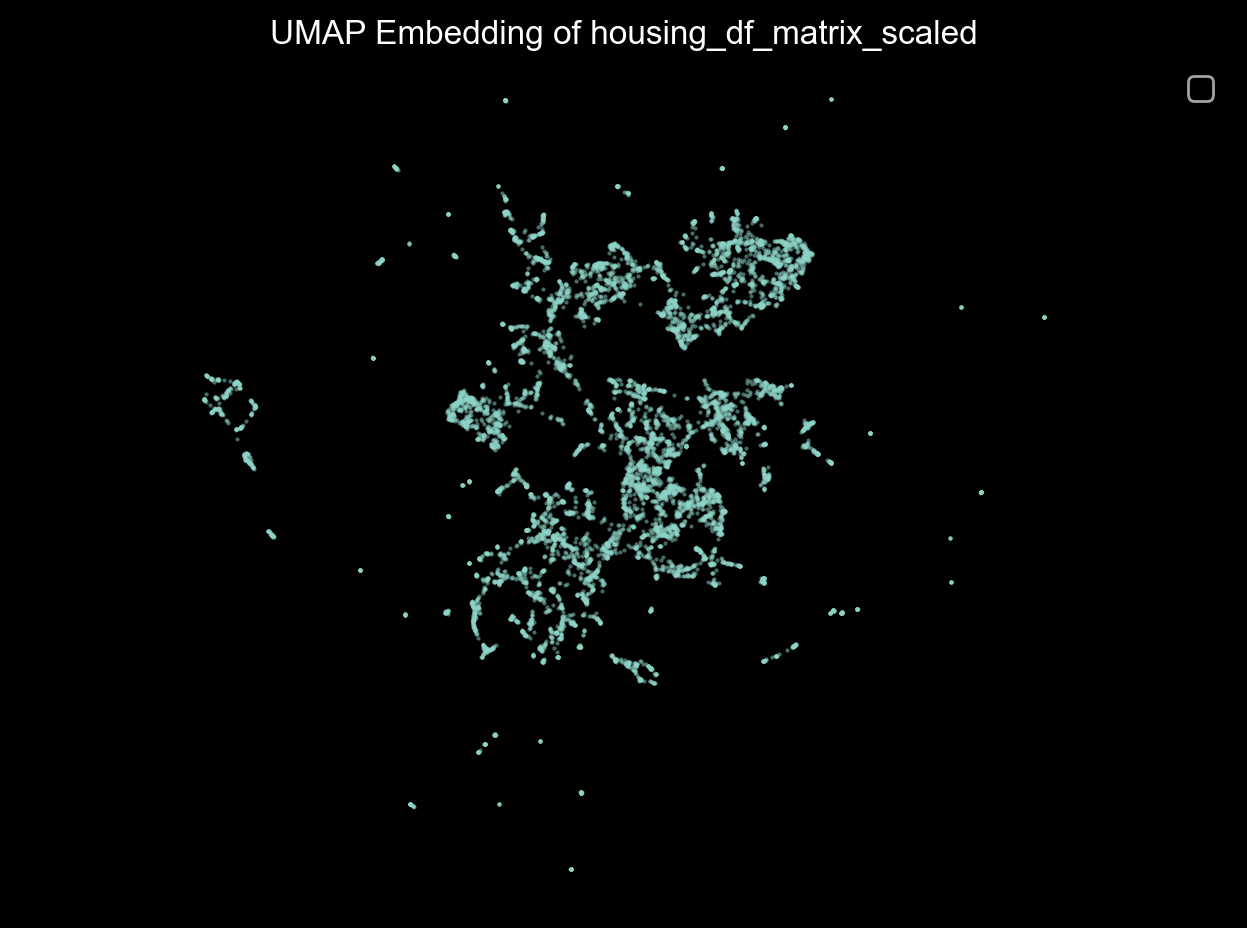

In [11]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], marker='.', alpha=0.5, s = 1)
plt.title('UMAP Embedding of housing_df_matrix_scaled')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.axis("off")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()


# determine clusters

## DBSCAN

In [12]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=9)
labels = dbscan.fit_predict(umap_result)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


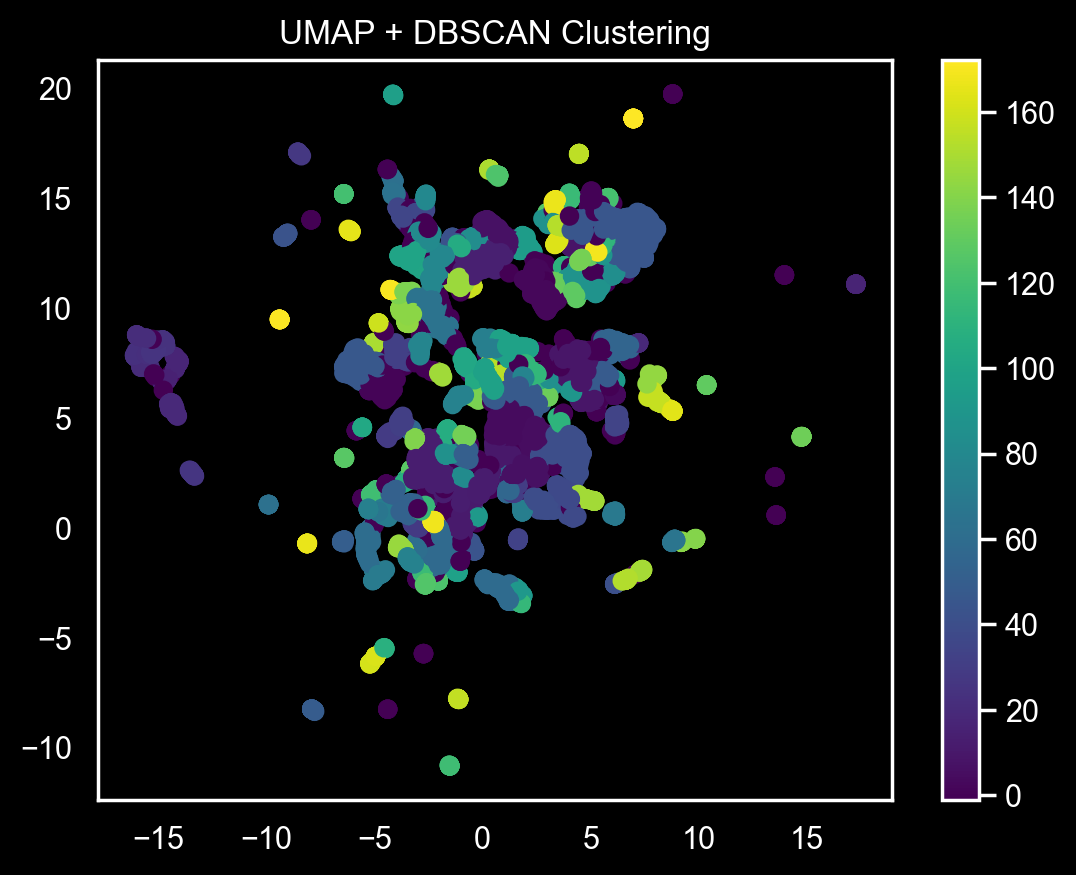

number of cluster: 173
number of noise: 416


In [13]:
# plotting the clusters
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis')
plt.title('UMAP + DBSCAN Clustering')
plt.colorbar()
plt.show()
print (f'number of cluster: {n_clusters_}')
print (f'number of noise: {n_noise_}')


eps: 0.1, min_samples: 9
number of cluster : 332
number of noise : 2939
eps: 0.1, min_samples: 10
number of cluster : 295
number of noise : 3476
eps: 0.1, min_samples: 11
number of cluster : 267
number of noise : 3979
eps: 0.1, min_samples: 12
number of cluster : 230
number of noise : 4578
eps: 0.125, min_samples: 9
number of cluster : 310
number of noise : 1720
eps: 0.125, min_samples: 10
number of cluster : 300
number of noise : 2103
eps: 0.125, min_samples: 11
number of cluster : 281
number of noise : 2584
eps: 0.125, min_samples: 12
number of cluster : 250
number of noise : 3170
eps: 0.15, min_samples: 9
number of cluster : 263
number of noise : 1035
eps: 0.15, min_samples: 10
number of cluster : 261
number of noise : 1310
eps: 0.15, min_samples: 11
number of cluster : 250
number of noise : 1644
eps: 0.15, min_samples: 12
number of cluster : 241
number of noise : 1938
eps: 0.175, min_samples: 9
number of cluster : 220
number of noise : 625
eps: 0.175, min_samples: 10
number of clus

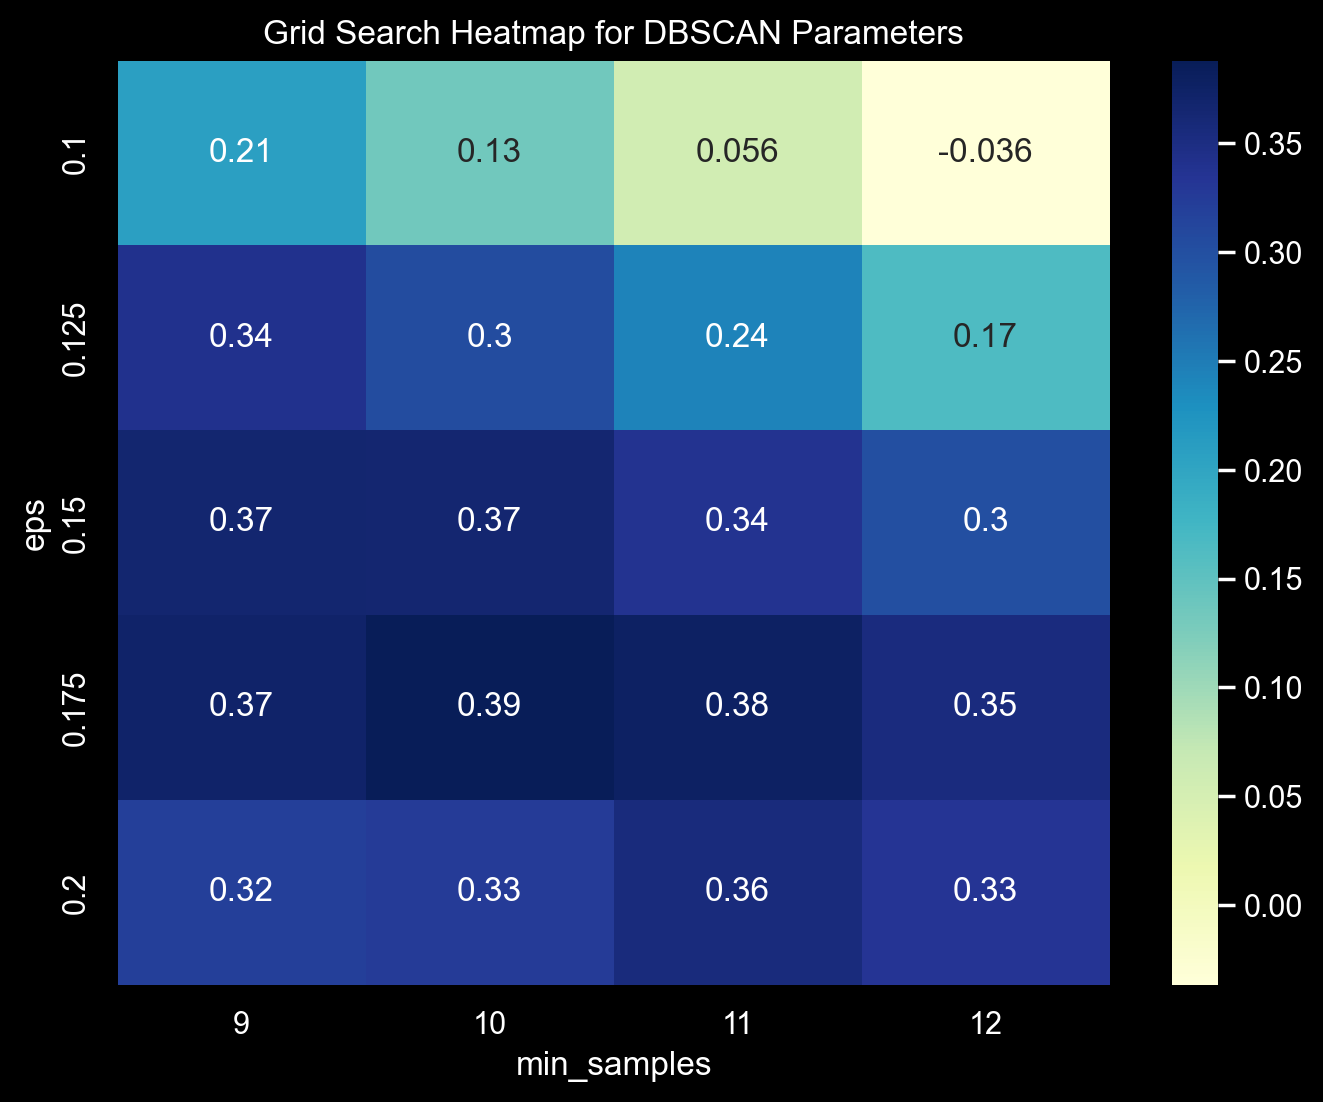

In [14]:
# decide parameters using gridsearch
# Define parameter grid
param_grid = {'eps': [0.1, 0.125, 0.15, 0.175, 0.2],
              'min_samples': [9, 10, 11, 12]}

# Initialize arrays to store silhouette scores
silhouette_scores = np.zeros((len(param_grid['eps']), len(param_grid['min_samples'])))

# Iterate over parameter combinations
for i, params in enumerate(ParameterGrid(param_grid)):
    # Fit DBSCAN with current parameter combination
    dbscan = DBSCAN(**params)
    dbscan.fit(umap_result)
    labels = dbscan.fit_predict(umap_result)
    n_clusters_ = len(set(labels))-(1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    eps_value = params['eps']
    min_samples_value = params['min_samples']
    
    print(f"eps: {eps_value}, min_samples: {min_samples_value}")
    print (f'number of cluster : {n_clusters_}')
    print (f'number of noise : {n_noise_}')
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(umap_result, dbscan.labels_)
    silhouette_scores[i // len(param_grid['min_samples']), i % len(param_grid['min_samples'])] = silhouette_avg

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(silhouette_scores, annot=True, cmap="YlGnBu", xticklabels=param_grid['min_samples'], yticklabels=param_grid['eps'])
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Grid Search Heatmap for DBSCAN Parameters')
plt.show()


## HDBSCAN

## Kmeans

In [15]:
from sklearn.cluster import KMeans
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(umap_result)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(umap_result, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.37915552


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.40812877


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.41102046


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.44839898


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.4380918


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 The average silhouette_score is : 0.4210242


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8 The average silhouette_score is : 0.4424074


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9 The average silhouette_score is : 0.4333106


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10 The average silhouette_score is : 0.43106666


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packa

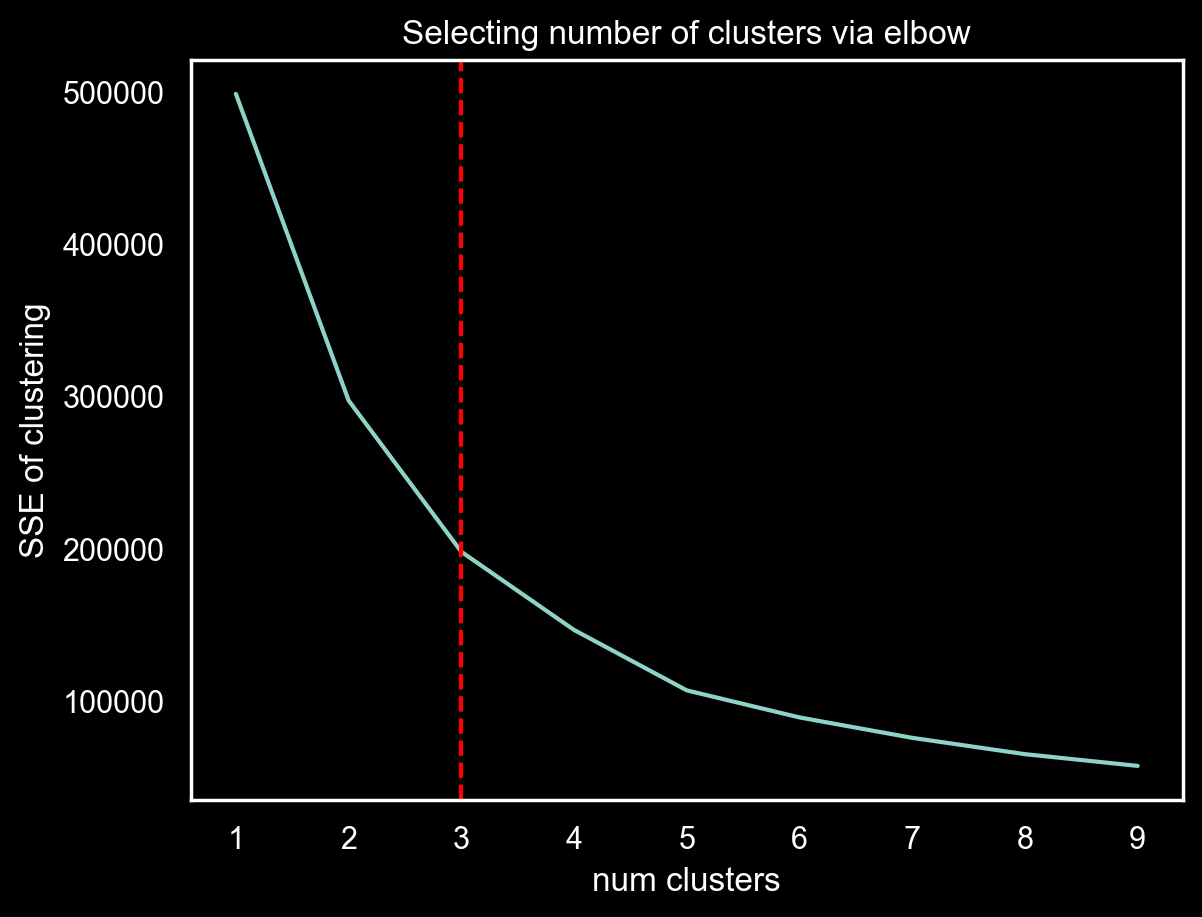

In [16]:
sse=[]
maxk = 10
for k in range(1,maxk):
    clust = cluster.KMeans(n_clusters=k)
    clust.fit(umap_result)
    sse.append(clust.inertia_)

# finds the location of max curvature (max of double derivative)
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="red", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');

In [17]:
# try 4 clusters
clusterer_kmeans = cluster.KMeans(n_clusters=4, random_state=10)
cluster_labels_kmeans = clusterer_kmeans.fit_predict(umap_result)

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


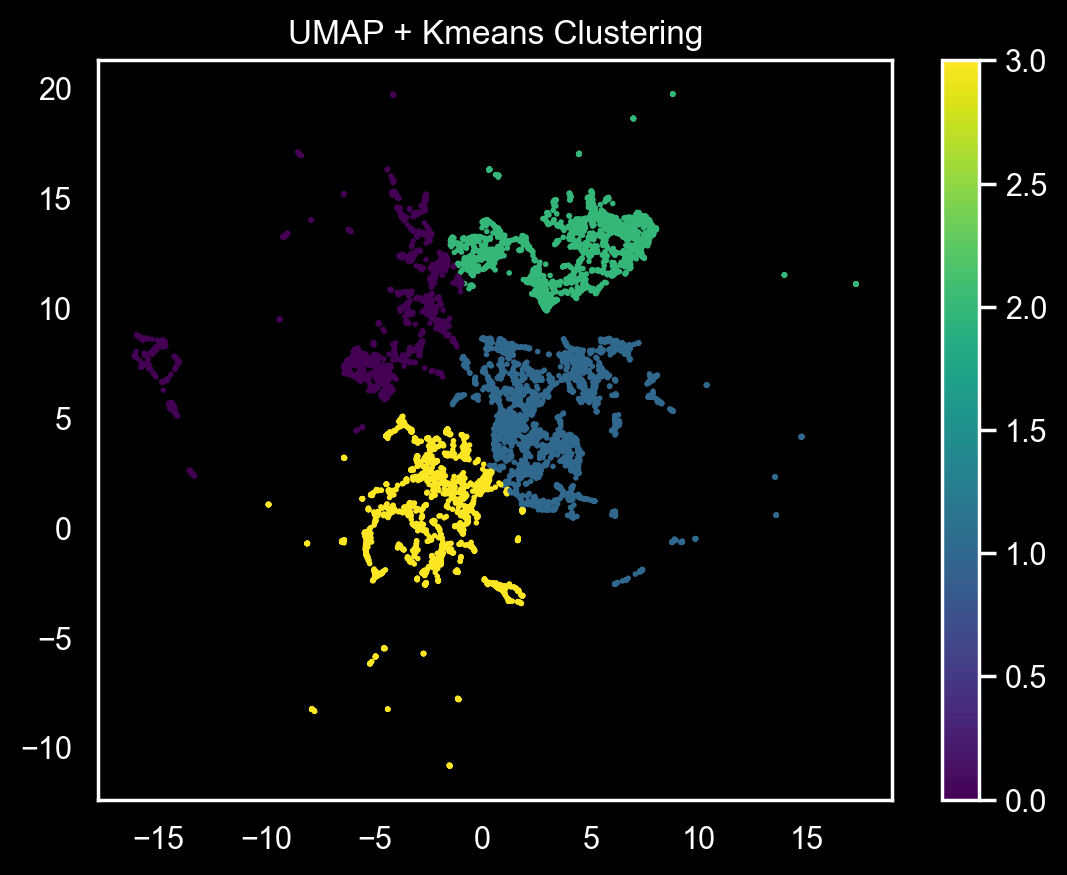

In [18]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels_kmeans, cmap='viridis', s = 1)
plt.title('UMAP + Kmeans Clustering')
plt.colorbar()
plt.show()

# GMM 


In [19]:
range_n_clusters = [2 ,3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters)
    clusterer.fit(umap_result)
    cluster_labels = clusterer.predict(umap_result)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(umap_result, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 2 The average silhouette_score is : 0.3734335
For n_clusters = 3 The average silhouette_score is : 0.36573198
For n_clusters = 4 The average silhouette_score is : 0.38193506
For n_clusters = 5 The average silhouette_score is : 0.4172606
For n_clusters = 6 The average silhouette_score is : 0.38206923
For n_clusters = 7 The average silhouette_score is : 0.34632438
For n_clusters = 8 The average silhouette_score is : 0.39146113
For n_clusters = 9 The average silhouette_score is : 0.37207627
For n_clusters = 10 The average silhouette_score is : 0.34964868


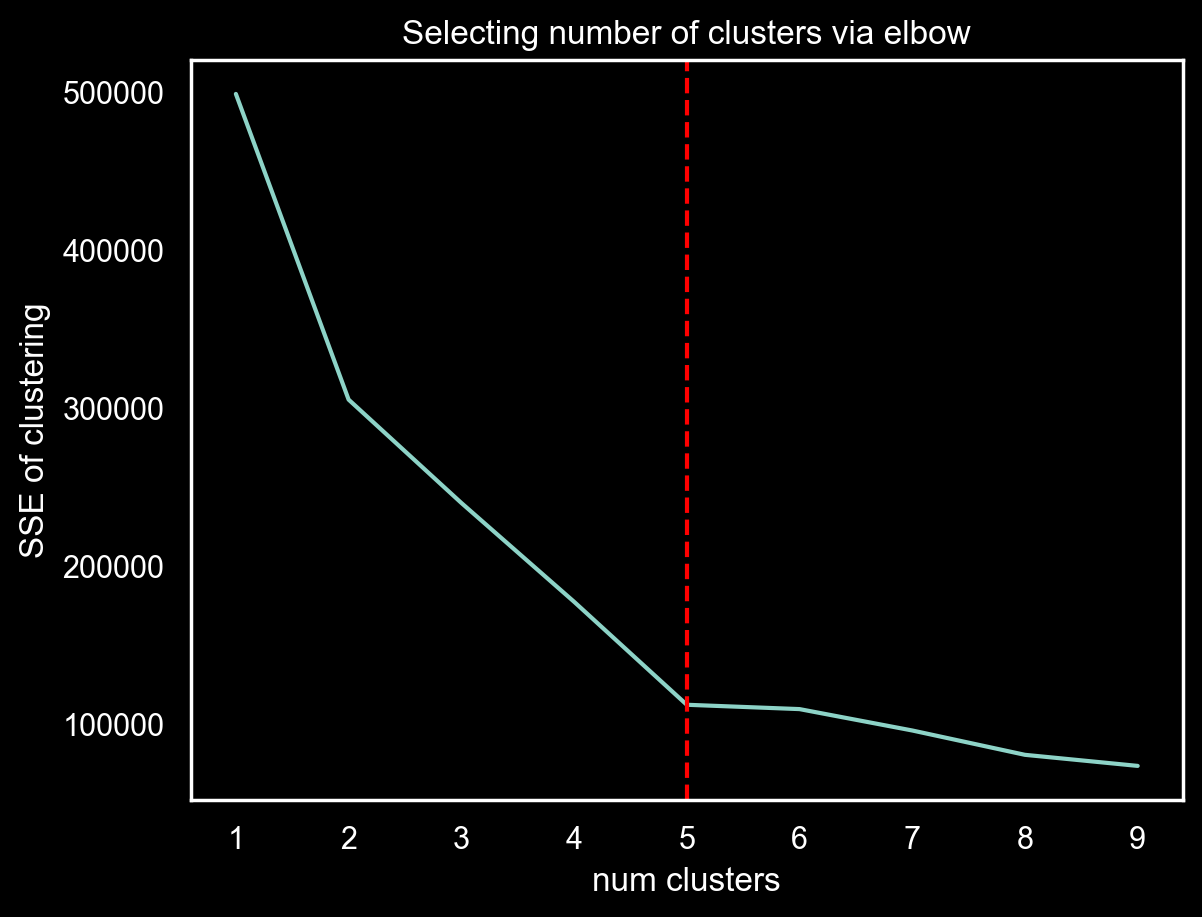

In [20]:
sse=[]
maxk = 10
for k in range(1,maxk):
    clust = GaussianMixture(n_components=k)
    clust.fit(umap_result)
    
    distances = []
    for i, center in enumerate(clust.means_):
        distances.append(np.sum((umap_result[clust.predict(umap_result) == i] - center) ** 2))
    
    # Sum the squared distances to get the SSE
    sse.append(np.sum(distances)) 

# finds the location of max curvature (max of double derivative)
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="red", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');

In [21]:
# try 5 clusters
clusterer_gmm = GaussianMixture(n_components=5)
clusterer_gmm.fit(umap_result)
cluster_labels_gmm = clusterer_gmm.predict(umap_result)

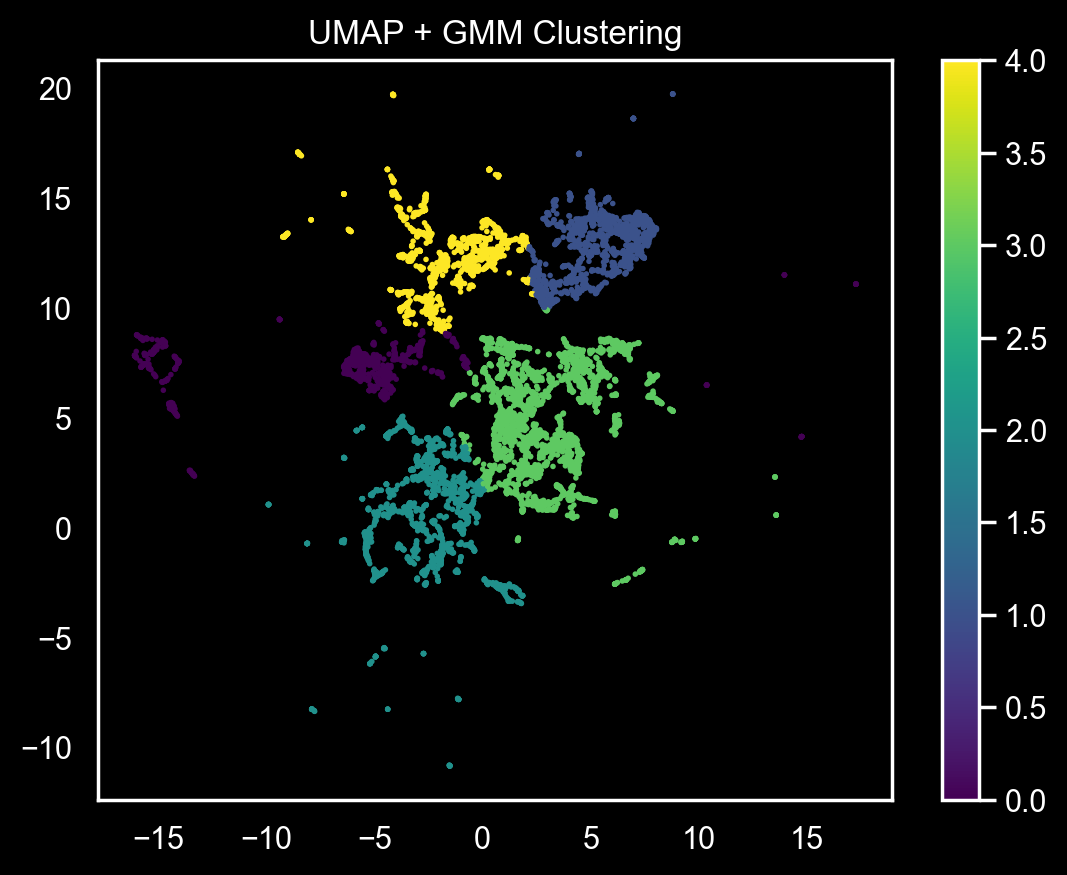

In [22]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels_gmm, cmap='viridis', s = 1)
plt.title('UMAP + GMM Clustering')
plt.colorbar()
plt.show()

## Predicting the Model

### DBSCAN

### KMeans

In [23]:
# Get centroids of each cluster
centroids = clusterer_kmeans.cluster_centers_

# Initialize NearestNeighbors using the result we got from UMAP (dimensionality reduction)
knn = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn.fit(umap_result)

# Find the 5 nearest neighbors for each centroid through indices
nn_i_kmeans = {} # indices of the nearest neighbor list
for i, centroid in enumerate(centroids):
    distances, indices = knn.kneighbors([centroid])
    nn_i_kmeans[i] = indices[0]
    
# Map nearest neighbors back to original data points
nn_data_kmeans = {} # list of original data corresponding to the nearest neighbors
for i, labels in enumerate(cluster_labels_kmeans):
    if labels not in nn_data_kmeans:
        nn_data_kmeans[labels] = []
    original_indices = nn_i_kmeans[labels]
    neighbors_data = housing_df_matrix_scaled[original_indices]  # actual data for that neighbor 
    nn_data_kmeans[labels].append(neighbors_data)


nn_dfs_kmeans = [] # dataframe to show the data computed for nearest neighbor
columns = housing_df_revised.columns
for label, neighbors_data_list in nn_data_kmeans.items():
    for i, neighbors_data in enumerate(neighbors_data_list):
        df = pd.DataFrame(neighbors_data, columns=columns)
        df['Cluster'] = label
        nn_dfs_kmeans.append(df)

# Concatenate all DataFrames into one
all_nn_df_kmeans = pd.concat(nn_dfs_kmeans, ignore_index=True)
all_nn_df_kmeans 

,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,Cluster
0,-0.481426,-0.434726,-0.513433,-0.004426,-0.158741,-0.166319,-0.142198,-0.157370,-0.021778,-0.418276,0.071949,0.423651,0.585088,0.040440,-1.048515,0.971970,2
1,-0.481426,-0.434726,-0.712758,0.102903,-0.128230,-0.188574,-0.169501,-0.185243,-0.079472,-0.443295,0.071949,0.423651,0.585088,0.040440,-1.064099,0.974340,2
2,-0.481426,-0.434726,-0.827154,0.083882,-0.160437,-0.228355,-0.170909,-0.221700,-0.075163,-0.423686,0.071949,0.423651,0.585088,0.040440,-1.052363,0.970128,2
3,-0.481426,-0.434726,-0.972748,0.011351,-0.146876,-0.289123,-0.221012,-0.275313,-0.051896,-0.193555,-0.020293,0.371121,0.591818,-0.195263,-0.947245,1.026860,2
4,-0.481426,-0.434726,-0.582764,0.087749,-0.002796,-0.170585,-0.212849,-0.152110,0.052374,-0.195832,-0.020293,0.371121,0.591818,-0.195263,-0.942030,1.022478,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48175,-0.481426,-0.434726,-0.284642,-0.365808,-0.159758,-0.217632,-0.205249,-0.211138,-0.070424,-0.468198,0.748666,0.937561,0.964483,1.217919,-1.611392,-0.091157,3
48176,-0.481426,-0.434726,-0.776022,0.067038,-0.151961,-0.216709,-0.211442,-0.210978,-0.076025,-0.494155,0.748666,0.937561,0.964483,1.217919,-1.617229,-0.099035,3
48177,-0.481426,-0.434726,-0.166781,-0.383790,-0.153656,-0.209790,-0.183294,-0.194894,0.001532,-0.474390,0.748666,0.937561,0.964483,1.217919,-1.610293,-0.093829,3
48178,-0.481426,-0.434726,-0.080117,-0.161378,-0.136706,-0.118119,-0.070983,-0.099462,0.083397,-0.494371,0.748666,0.937561,0.964483,1.217919,-1.616850,-0.101324,3


### GMM

In [25]:
# Get means of each Gaussian component
means = clusterer_gmm.means_

# Initialize NearestNeighbors using the result we got from UMAP (dimensionality reduction)
knn = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn.fit(umap_result)

# Find the 5 nearest neighbors for each mean through indices
nn_i_gmm = {} # indices of the nearest neighbor list
for i, mean in enumerate(means):
    distances, indices = knn.kneighbors([mean])
    nn_i_gmm[i] = indices[0]
    
# Map nearest neighbors back to original data points
nn_data_gmm = {} # list of original data corresponding to the nearest neighbors
for i, labels in enumerate(cluster_labels_gmm):
    if labels not in nn_data_gmm:
        nn_data_gmm[labels] = []
    original_indices = nn_i_gmm[labels]
    neighbors_data = housing_df_matrix_scaled[original_indices]  # actual data for that neighbor 
    nn_data_gmm[labels].append(neighbors_data)

nn_dfs_gmm = [] # dataframe to show the data computed for nearest neighbor
columns = housing_df_revised.columns
for label, neighbors_data_list in nn_data_gmm.items():
    for i, neighbors_data in enumerate(neighbors_data_list):
        df = pd.DataFrame(neighbors_data, columns=columns)
        df['Cluster'] = label
        nn_dfs_gmm.append(df)

# Concatenate all DataFrames into one
all_nn_df_gmm = pd.concat(nn_dfs_gmm, ignore_index=True)
all_nn_df_gmm

,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,Cluster
0,-0.481426,-0.434726,-0.383438,-0.247681,0.088737,-0.199067,-0.211442,-0.195001,-0.079472,-0.257876,-0.440198,-0.064917,0.021932,-0.763485,-0.699955,0.680516,1
1,-0.481426,-0.434726,0.071543,-0.501211,-0.130942,-0.205985,-0.197649,-0.196073,-0.036385,-0.287780,-0.250530,-0.377841,-0.408754,-0.638674,-0.765271,1.021616,1
2,-0.481426,-0.434726,-0.449302,0.220785,0.659973,-0.097594,-0.182168,-0.077052,0.110111,-0.422724,-0.060414,-0.126732,0.017166,-0.417567,-0.569638,0.603784,1
3,-0.481426,-0.434726,-0.529032,-0.372453,-0.172082,-0.266638,-0.328257,-0.259229,-0.090675,-0.490403,-0.271654,-0.281585,-0.087316,-0.412916,0.069642,0.967191,1
4,-0.481426,-0.434726,-0.660760,0.628425,1.595647,-0.039824,-0.241279,-0.044884,-0.063099,-0.389847,-0.372011,-0.174745,0.020604,-0.450023,-0.519947,1.166627,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48175,-0.481426,0.527714,-0.418970,-0.425775,-0.148573,-0.268252,-0.169501,-0.253868,-0.035523,-0.477713,-0.074778,0.428547,0.020108,1.504045,-0.140526,0.120507,2
48176,-0.481426,0.527714,-0.586230,-0.266764,-0.160437,-0.256376,-0.309960,-0.243145,-0.038108,-0.490049,-0.074778,0.428547,0.020108,1.504045,-0.138720,0.124593,2
48177,-0.481426,0.527714,0.101008,-0.573053,-0.155079,-0.235389,-0.084775,-0.219556,-0.005362,-0.467917,-0.074778,0.428547,0.020108,1.504045,-0.130041,0.115824,2
48178,-0.481426,0.527714,0.097542,-0.427016,-0.121450,-0.180617,-0.071827,-0.162726,0.042034,-0.487722,-0.074778,0.428547,0.020108,1.504045,-0.140582,0.124560,2


### Splitting Training and Testing Dataset


In [27]:
#split dataset into training and testing 80/20
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(housing_df_revised, test_size=0.2, random_state=42)


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord
5852,4.0,5.0,7151.0,349.601454,0.500000,2391500.0,6835.0,2500000.0,108500.0,3.139552,0.002439,0.013121,0.008463,0.002438,35.128628,-106.694176
455,4.0,3.0,3572.0,309.350504,0.219904,1054400.0,2533.0,1105000.0,50600.0,852.593621,0.001880,0.019737,0.016330,0.001292,57.071860,-135.365370
9441,3.0,2.0,1128.0,155.141844,0.160000,167300.0,1500.0,175000.0,7700.0,225.595874,0.002926,0.029038,0.022008,0.002095,42.851658,-106.292840
8498,3.0,1.0,984.0,127.032520,0.070000,128900.0,1924.0,125000.0,-3900.0,124.515243,0.007485,0.023740,0.021401,0.000000,44.205193,-72.507400
1197,3.0,2.0,1844.0,317.245119,0.160000,590100.0,2483.0,585000.0,-5100.0,11.863183,0.003154,0.031282,0.024167,0.002837,39.684120,-105.074330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,3.0,3.0,1642.0,158.038977,0.242746,256800.0,1749.0,259500.0,2700.0,40.958655,0.004965,0.035810,0.026526,0.002966,32.376890,-106.747910
5191,3.0,3.0,2171.0,170.427913,0.120000,326700.0,2199.0,369999.0,43299.0,50.188761,0.003830,0.027507,0.022554,0.001559,40.712738,-96.681020
5390,5.0,4.0,4015.0,193.026152,0.290000,772000.0,3971.0,775000.0,3000.0,6.868102,0.000987,0.004693,0.002607,0.000802,36.325580,-115.219080
860,4.0,2.0,1383.0,694.143167,0.204900,1017500.0,3099.0,960000.0,-57500.0,19.390053,0.001737,0.028583,0.022270,0.002493,37.539482,-122.035130


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord
4294,2.0,1.0,756.0,151.984127,0.200000,117300.0,1350.0,114900.0,-2400.0,3.766177,0.009257,0.045170,0.030560,0.006728,45.007630,-93.312960
4823,3.0,1.0,1116.0,183.691756,0.280000,205000.0,1325.0,205000.0,0.0,32.879715,0.001734,0.008285,0.006358,0.000578,38.998886,-93.964100
2114,3.0,2.0,2508.0,119.577352,0.180000,298500.0,1798.0,299900.0,1400.0,117.911391,0.004123,0.023463,0.017907,0.001557,42.899640,-112.440680
8464,3.0,3.0,5022.0,115.491836,5.900000,558800.0,2999.0,580000.0,21200.0,186.079794,0.003504,0.007007,0.005005,0.001502,38.344116,-109.183220
1458,4.0,1.0,1335.0,220.973783,0.580000,296100.0,2400.0,295000.0,-1100.0,13.680796,0.000884,0.013705,0.010054,0.001767,41.713486,-72.938576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,3.0,3.0,3083.0,430.100551,0.260000,1321900.0,6224.0,1326000.0,4100.0,6.963882,0.006884,0.032720,0.024064,0.004103,32.240400,-110.940560
6266,5.0,2.0,2526.0,150.395883,0.238751,380500.0,1794.0,379900.0,-600.0,215.864822,0.004505,0.031219,0.021637,0.003069,46.813915,-96.875840
1222,4.0,2.0,1942.0,301.235839,0.145776,586300.0,3028.0,585000.0,-1300.0,2.761027,0.007489,0.037435,0.024730,0.007263,39.765390,-104.927470
5606,3.0,2.0,1598.0,269.023780,0.210009,449300.0,2983.0,429900.0,-19400.0,35.411526,0.001440,0.012848,0.011341,0.000603,42.745445,-71.470430
